In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using Theano backend.


AttributeError: module 'tensorflow_core.compat.v2' has no attribute '__internal__'

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


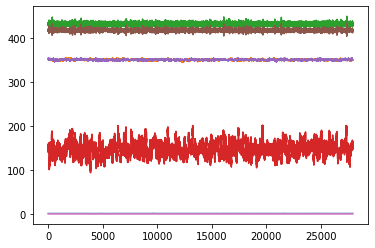

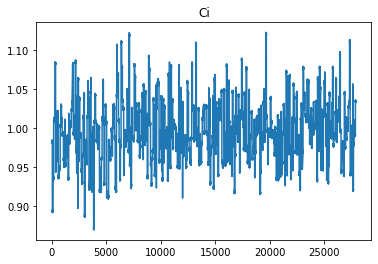

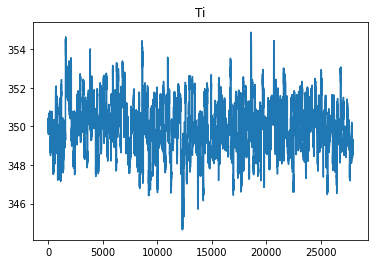

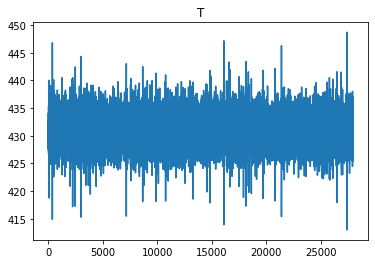

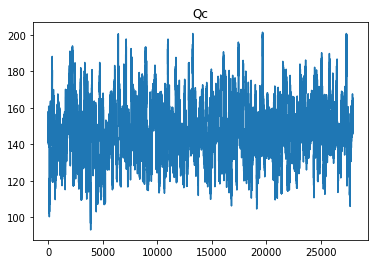

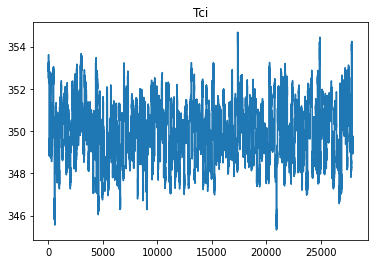

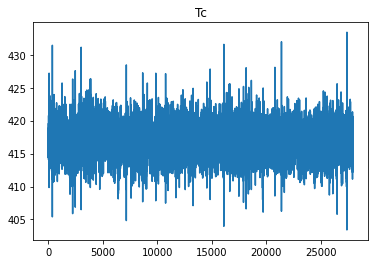

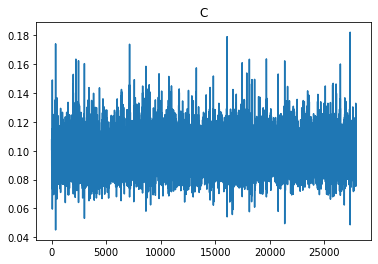

In [ ]:
df = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=df.head(27922)
d=df
dfRaw=d
# print(dfRaw.shape)
# print(dfRaw.columns)

d=d.iloc[:,2:9]
plt.plot(d)
plt.show()
name=['Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C']

for i in range(7):
    plt.plot(d.iloc[:,i])
    plt.title(name[i], fontdict=None, loc='center', pad=None)
    plt.show()

In [2]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")
a=normal_data.describe().transpose()

from IPython.display import display, HTML

display(HTML(a.to_html()))



NameError: name 'dfRaw' is not defined

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


1861
------------------------------------------------------------------------
Training for fold 0 ...


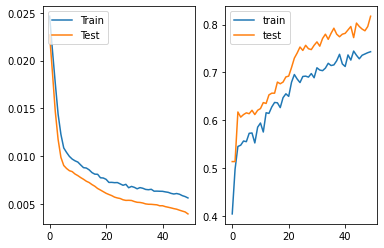

------------------------------------------------------------------------
Training for fold 1 ...


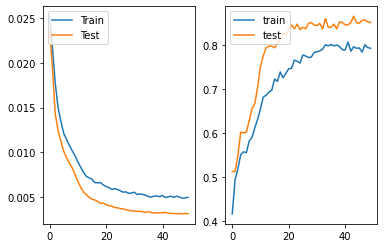

------------------------------------------------------------------------
Training for fold 2 ...


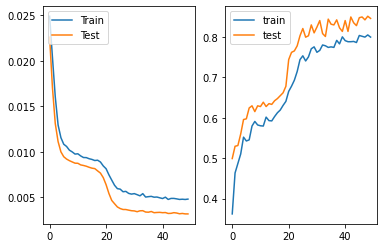

------------------------------------------------------------------------
Training for fold 3 ...


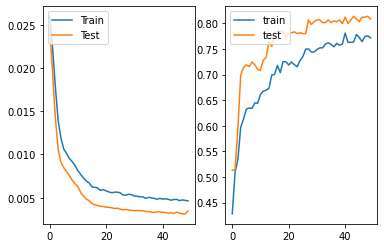

------------------------------------------------------------------------
Training for fold 4 ...


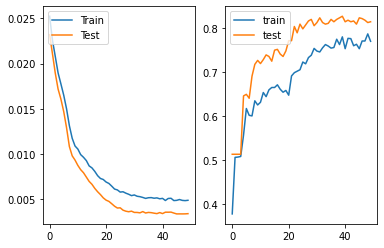

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy


from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing
from sklearn.model_selection import KFold


df = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=df.head(1861)
# all features
print(len(df))
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.3)
n_features = x.shape[1]

inputs = np.concatenate((train_data, test_data), axis=0)


# Define the K-fold Cross Validator
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc=[]
val_acc=[]
prediction_loss_error=[]

i=0

for train, test in kfold.split(inputs):
    
    # # model
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
    encoder.add(keras.layers.Dropout(0.1))
    encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
    encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
    decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
    decoder.add(keras.layers.Dropout(0.1))
    decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

    autoencoder = keras.Sequential([encoder, decoder])

    autoencoder.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mean_squared_error,'accuracy'])
    

    # train model
    es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, restore_best_weights=True)
#     history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    # Fit data to model
    history = autoencoder.fit(x=inputs[train], y=inputs[train], epochs=50, verbose=0, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Mean Squared error
    train_predicted_x = autoencoder.predict(x=inputs[train])
    train_events_mse=sklearn.metrics.mean_squared_error(inputs[train], train_predicted_x)

    prediction_loss_error.append(train_events_mse)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    
    
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
#     ax1.title('Model Loss')
#     ax1.ylabel('Loss')
#     ax1.xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
#     ax2.title('model accuracy')
#     ax2.ylabel('accuracy')
#     ax2.xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()

    i=i+1


# Increase fold number
i = i + 1

# print(f'> Loss: {np.mean(prediction_loss_error)}')
# print(f'> acc: {(acc)}')
# print(f'> val_acc: {(val_acc)}')

In [5]:
print(n_features)

7


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE per signal:
Signal 1: 0.0008180680451914668
Signal 2: 0.0009108100784942508
Signal 3: 0.002782161347568035
Signal 4: 0.0012475652620196342
Signal 5: 0.0010212811175733805
Signal 6: 0.002586222952231765
Signal 7: 0.002868196927011013

Overall MSE:
0.001747758
Cut-off: 0.0028423862531781197


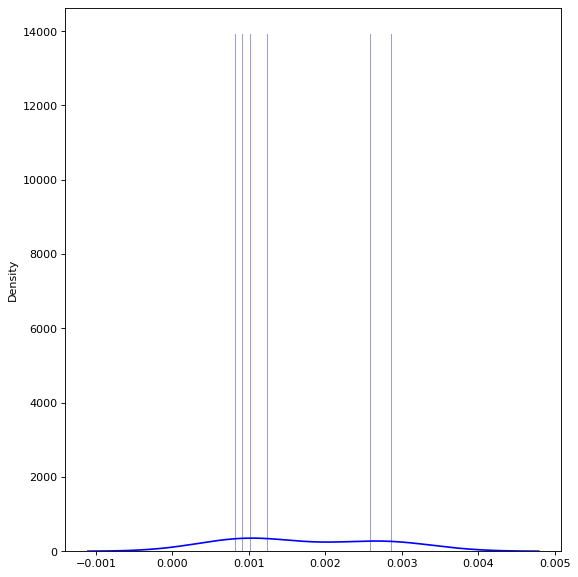

In [20]:

# Mean Squared error
# train_predicted_x = autoencoder.predict(x=train_data)
# train_events_mse =  keras.losses.mean_squared_logarithmic_error(train_data, train_predicted_x)
# cut_off = np.percentile(train_events_mse, 95)

# loss distribution

# plt.figure(figsize=(8,9), dpi=80)
# sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
# plt.xlim([0., 0.01]);


# print('MSE')
# print(cut_off)
# print(np.average(train_events_mse.numpy()))


# Compute the MSLE for each signal separately
signal_mse = []
for i in range(train_data.shape[1]):
    mse = keras.losses.mean_squared_logarithmic_error(train_data[:,i], train_predicted_x[:,i])
    signal_mse.append(mse)

# Convert the list to a numpy array
signal_mse = np.array(signal_mse)

# Get the 95th percentile of the signal MSEs
cut_off = np.percentile(signal_mse, 95)

# Plot the distribution of signal MSEs
plt.figure(figsize=(8,9), dpi=80)
sns.distplot(signal_mse, bins=200, kde=True, color='blue')


# Print the MSE for each signal, as well as the overall MSE
print('MSE per signal:')
for i, mse in enumerate(signal_mse):
    print(f'Signal {i+1}: {mse}')
print('\nOverall MSE:')
print(np.mean(signal_mse))
print('Cut-off:', cut_off)






In [38]:
## Import dataset whihc has a fault to be detected

df = pd.read_excel('Ci amp 5 Fault 4 0.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)

d=df.iloc[:,1:8]
# plt.plot(d)
# plt.show()
name=['Class','Ci', 'Ti', 'C', 'T', 'Qc', 'Tci', 'TC']


# for i in range(7):
#     plt.plot(d.iloc[:,i])
#     plt.title(name[i], fontdict=None, loc='center', pad=None)
#     plt.show()


plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, 7)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_logarithmic_error(abnormal_x, predicted_x)

signal_mse = []
for i in range(6):
    mse = keras.losses.mean_squared_logarithmic_error(abnormal_x[:,i], predicted_x[:,i])


# Convert the list to a numpy array
    signal_mse = np.array(signal_mse)

    # Get the 95th percentile of the signal MSEs
    cut_off = np.percentile(signal_mse, 95)

    # Plot the distribution of signal MSEs
    plt.figure(figsize=(8,9), dpi=80)
    sns.distplot(signal_mse, bins=200, kde=True, color='blue')











IndexError: cannot do a non-empty take from an empty axes.

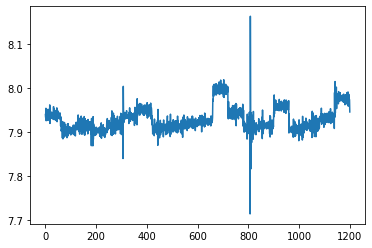

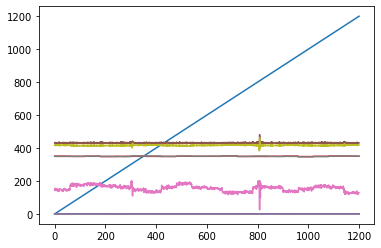

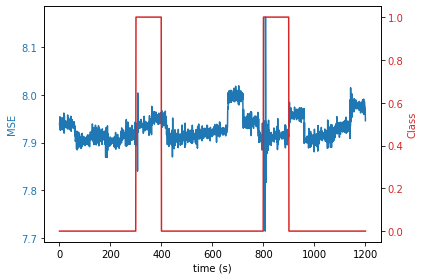

In [8]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Ci amp 5 Fault 4 0.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

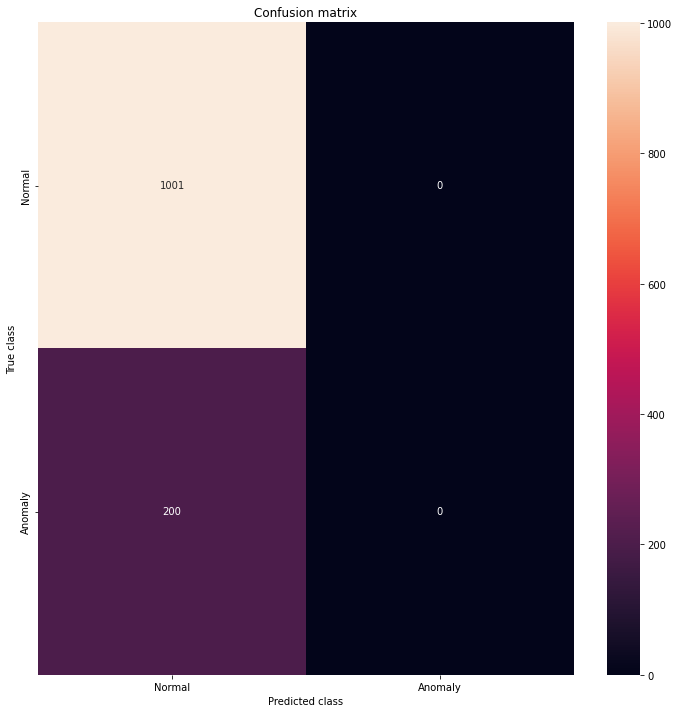

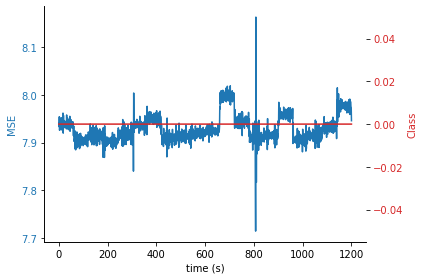

In [12]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Final=pd.DataFrame(abnormal_events_df.mse)


cond = (Final['mse']<7.85) & (Final['mse']>8.1)


Final['Class'] = np.where(cond, 1, 0)


df = pd.read_excel('Ci amp 5 Fault 4 0.xlsx',engine='openpyxl')
LABELS=["Normal", "Anomaly"]
conf_matrix = confusion_matrix(df.Class, Final.Class.astype(int))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

df=Final.Class
data1 = Final.mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

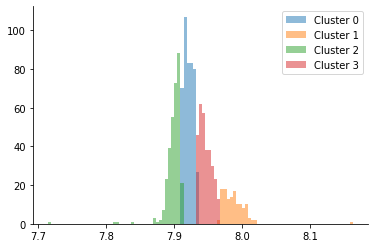

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False


data = abnormal_events_mse.numpy()

# determine which K-Means cluster each point belongs to
cluster_id = KMeans(4).fit_predict(data.reshape(-1, 1))

# determine densities by cluster assignment and plot
fig, ax = plt.subplots()
bins = np.linspace(data.min(), data.max(), 100)
for ii in np.unique(cluster_id):
    subset = data[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
plt.show()


In [11]:
cluster=pd.DataFrame(cluster)
cluster.to_excel('a.xlsx')

NameError: name 'cluster' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
%matplotlib inline

#Sample data
x = abnormal_events_mse.numpy()
num_components = 2

#Fit a model onto the data
data = np.array(x).reshape(-1,1)
model = GaussianMixture(n_components=num_components).fit(data)

clusters = model.predict(data)
df = pd.DataFrame(list(zip(x, clusters)), columns=['data', 'clusters'])
df
# print(df.to_excel('aa.xlsx'))

In [ ]:
from sklearn.neighbors import KernelDensity
from numpy import where, random, array, quantile
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston


X =  abnormal_events_mse.numpy().reshape(-1, 1)

x_ax = range(len(X))


kern_dens = KernelDensity()
kern_dens.fit(X)

scores = kern_dens.score_samples(X)
threshold = quantile(scores, .015)

print(threshold)
print(scores)


idx = where(scores <= threshold)
values = X[idx]
plt.plot(x_ax, X)
plt.scatter(idx,values, color='r')
plt.show()

In [ ]:

# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset

import numpy as np
from scipy.spatial.distance import cdist 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
 
#Defining our function 
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points 
 
 
#Load Data
data = X
pca = PCA(0)
  
#Transform the data
df = pca.fit_transform(data)
 
#Applying our function
label = kmeans(df,2,1000)
 
#Visualize the results
 
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()